In [100]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

from qiskit import BasicAer
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components import variational_forms
from qiskit.aqua.components.optimizers import COBYLA, SPSA

from embed_utils import MyVQC
from var_utils import MyRYRZ

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import pickle

def get_data(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

# BC

5-fold Random Forest Classification
Mean Accuracy: 71.65%
Mean F1 score: 40.90%
The four most important features are TUMOR-SIZE, BREAST-QUAD, DEG-MALIG and AGE respectively.


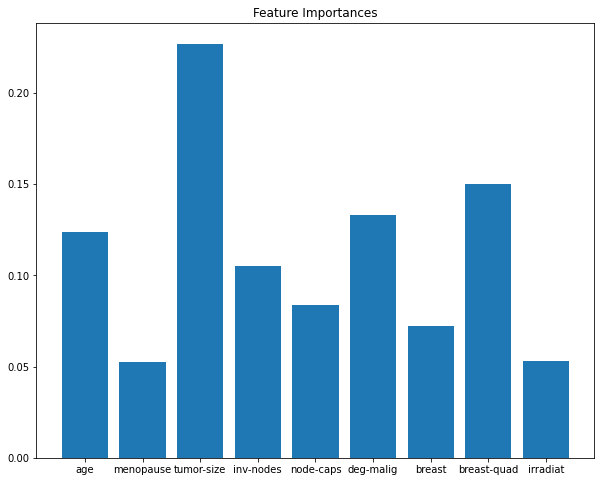

In [105]:
from bc_utils_ver2 import *

X_df, y_df = get_breast_cancer_data()
X, y = X_df.values, y_df.values

np.random.seed(123123)
selected_features_num = 4
_, __, feature_importances_list = kfold_randomforest(X, y)

# Feature selection from feature importances
selected_features = X_df.columns[sorted(range(X.shape[1]), key=lambda i: np.mean(feature_importances_list, axis=0)[i])[:-selected_features_num-1:-1]]
print('The four most important features are', ", ".join(selected_features[:-1]).upper() + f' and {selected_features[-1].upper()} respectively.')

# Visualize the feature importances
plt.figure(figsize=(10,8))
plt.bar(X_df.columns, np.mean(feature_importances_list, axis=0))
plt.title('Feature Importances')
plt.show()

In [143]:
import os
# Train VQC
def get_vqc_200(feature_map, \
              var_form, \
              backend, \
              optimizer, \
              seed, \
              X_train, X_test, y_train, y_test, \
              fold_path, \
              positivedata_duplicate_ratio=1, \
              shots=1024,
              randomizer="standard_normal",
              lamb=None):

    # Input preparation
    # Input dict
    training_input, test_input = get_input_dict_for_VQC(X_train, X_test, y_train, y_test, positivedata_duplicate_ratio)
    # Quantum instance
    quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)
   
    temp_model_name = os.path.join(fold_path, 'temp.npz')
    final_model_filename = os.path.join(fold_path, 'final_model.npz')

    # Callback function for collecting models' parameters and losses along the way
    training_loss_list, validation_loss_list = [], []
    training_acc, validation_acc = [], []

    # Run VQC
    vqc = MyVQC(optimizer, feature_map, var_form, training_input, test_input, randomizer=randomizer, lamb=lamb)
    vqc.random.seed(seed)
    model_filename = os.path.join(fold_path, f'_evalcount651.npz')
    vqc.load_model(model_filename)
    clear_output()
    print('Trained successfully!')
    
    result = {}

    # Evaluate a final model
    y_train_pred, y_test_pred = vqc.predict(X_train, quantum_instance)[1], vqc.predict(X_test,  quantum_instance)[1]
    acc_train, f1_train = np.mean(y_train_pred==y_train), f1_score(y_train, y_train_pred)
    acc_test, f1_test = np.mean(y_test_pred==y_test), f1_score(y_test, y_test_pred)
    clear_output()
    print(f'Final accuracy (test set): {acc_test:.2%} | Final accuracy (training set): {acc_train:.2%}')
    print(f'Final F1 score (test set): {f1_test:.2%} | Final F1 score (training set): {f1_train:.2%}')
    print(f'Final model is saved at {final_model_filename}.\nTemp models are saved at {temp_model_name}.')

    result['Training losses'], result['Validation losses'] = np.array(training_loss_list), np.array(validation_loss_list)
    result['Training accuracy logs'], result['Validation accuracy logs'] = np.array(training_acc), np.array(validation_acc)
    result['Training F1 score'], result['Training accuracy'] = f1_train, acc_train
    result['Test F1 score'], result['Test accuracy'] = f1_test, acc_test

    return result

def get_kfold_vqc(feature_map, \
              var_form, \
              backend, \
              optimizer_generator, \
              seed, \
              X, y, \
              model_foldername, \
              result_filename, \
              k=5, \
              positivedata_duplicate_ratio=1, \
              shots=1024, \
              seed_kfold=123123,
              randomizer="standard_normal",
              lamb=None):

    print('='*100)
    print(f'{k}-fold VQC Classification')
    print(f"Model is saved at {model_foldername}")
    if not os.path.exists(model_foldername):
        os.makedirs(model_foldername)
        
    # Final result initialization (dict)
    params_to_collect = ['Training losses', 'Validation losses', \
                         'Training accuracy', 'Test accuracy', \
                         'Training F1 score', 'Test F1 score', \
                         'Training accuracy logs', 'Validation accuracy logs']
    result = {key:[] for key in params_to_collect}
    # result['Default test accuracies'] = [] # Uncomment for validating the predicted accuracy
    np.random.seed(seed_kfold)
    kf = KFold(n_splits=k, shuffle=True)
    kf_id = list(kf.split(X))
    for (fold, (train_id, test_id)) in enumerate(kf_id, start=1):
        fold_path = os.path.join(model_foldername, f"fold_{fold}")
        if not os.path.exists(fold_path):
            os.makedirs(fold_path)
        print('='*100 + f'\nFold number {fold}\n' + '='*100)
        # Split the data
        X_train, X_test, y_train, y_test = X[train_id], X[test_id], y[train_id], y[test_id]
        # Train a model
        optimizer = optimizer_generator()
        result_onefold = get_vqc_200(feature_map, \
                                var_form, \
                                backend, \
                                optimizer, \
                                seed, \
                                X_train, X_test, y_train, y_test, \
                                fold_path, \
                                positivedata_duplicate_ratio, \
                                shots,
                                  randomizer,
                                  lamb)
        # Save the trained model to the final zip file
        # Final model
        final_model_filename_fold = os.path.join(fold_path, f"final.npz")
        # Collect results
        for key in params_to_collect:
            result[key].append(result_onefold[key])

    # Average accuracies and f1 scores
    dict_items_without_meanvalues = list(result.items())
    for key, value in dict_items_without_meanvalues:
        result[key + ' (mean)'] = np.mean(value, axis=0)
    # Convert to numpy arrays
    for key, value in result.items():
        if type(value)==list:
            result[key] = np.array(value)
    # Save final results
    with open(result_filename, 'wb') as f:
        pickle.dump(result, f)
    clear_output()
    print('='*100)
    print('='*35 + f' {k}-fold VQC Classification ' + '='*35)
    print(f"Training accuracy (mean): {result['Training accuracy (mean)']:.2%} | Test accuracy (mean): {result['Test accuracy (mean)']:.2%}")
    print(f"Training F1 score (mean): {result['Training F1 score (mean)']:.2%} | Test F1 score (mean): {result['Test F1 score (mean)']:.2%}")
    print(f'All models are saved at {model_foldername}.\nResults are saved at {result_filename}.')
    print('='*100)

    return result

In [148]:
from qiskit import QuantumCircuit

file_name = 'BC_self_learn_encoder_standard_4fold_depth1_700'

X, y = X_df[selected_features].values, y_df.values
X_binary_encoded = binary_encoder(X)

# Preparing inputs for feeding VQC
num_qubit = len(X_binary_encoded[0])//3
# Custom Feature Map
feature_map = QuantumCircuit(num_qubit)
var_form = MyRYRZ(num_qubit, 1)
backend = QasmSimulator({"method": "statevector_gpu"})

seed, epoch = 700, 300
optimizer = lambda: SPSA(epoch)
result_bc_200_depth1 = get_kfold_vqc(feature_map, \
                    var_form, \
                    backend, \
                    optimizer, \
                    seed, \
                    X_binary_encoded, y, \
                    f'models/{file_name}_model', \
                    f'results/{file_name}_epoch200_results.pkl', \
                    k=4,
                    randomizer="standard_normal")

=================================== 4-fold VQC Classification ===================================
Training accuracy (mean): 73.89% | Test accuracy (mean): 69.56%
Training F1 score (mean): 55.12% | Test F1 score (mean): 45.25%
All models are saved at models/BC_self_learn_encoder_standard_4fold_depth1_700_model.
Results are saved at results/BC_self_learn_encoder_standard_4fold_depth1_700_epoch200_results.pkl.


In [140]:
result_bc_200_depth1

{'Training losses': array([], shape=(4, 0), dtype=float64),
 'Validation losses': array([], shape=(4, 0), dtype=float64),
 'Training accuracy': array([0.71495327, 0.69626168, 0.71627907, 0.7255814 ]),
 'Test accuracy': array([0.69444444, 0.69444444, 0.66197183, 0.76056338]),
 'Training F1 score': array([0.51968504, 0.5323741 , 0.56115108, 0.5203252 ]),
 'Test F1 score': array([0.47619048, 0.47619048, 0.47826087, 0.62222222]),
 'Training accuracy logs': array([], shape=(4, 0), dtype=float64),
 'Validation accuracy logs': array([], shape=(4, 0), dtype=float64),
 'Training losses (mean)': array([], dtype=float64),
 'Validation losses (mean)': array([], dtype=float64),
 'Training accuracy (mean)': 0.7132688545968268,
 'Test accuracy (mean)': 0.7028560250391236,
 'Training F1 score (mean)': 0.5333838556195566,
 'Test F1 score (mean)': 0.513216011042098,
 'Training accuracy logs (mean)': array([], dtype=float64),
 'Validation accuracy logs (mean)': array([], dtype=float64)}

In [124]:
get_data('results/BC_self_learn_encoder_standard_4fold_depth1_666_lamb0.02_results.pkl')['Validation accuracy logs (mean)'][-200]

0.7411482785602503

## 3-1 encoding

In [22]:
files = {
    '(3,1)-QRAC_depth1': 'results/test_qrac31_results.pkl/allfolds.pkl',
    '(3,1)-QRAC_depth4': 'results/test_qrac31_depth4_results.pkl/allfolds.pkl'
}

datas = {
    'method':[],
    'acc':[],
    'acc_last10':[],
    'f1':[]
}

for key, fname in files.items():
    data = get_data(fname)
    datas['method'].append(key)
    datas['acc'].append(data['Test accuracies (mean)'][-1])
    datas['acc_last10'].append(np.mean(data['Test accuracies (mean)'][-10:]))
    datas['f1'].append(data['Test F1 scores (mean)'][-1])

In [23]:
QRAC_result = pd.DataFrame(datas)

## TE-encoding

In [93]:
get_data('results/BC_self_learn_encoder_standard_4fold_depth1_700_results.pkl')['Validation accuracy logs (mean)'][-200]

0.6886248043818467

In [94]:
get_data('results/BC_self_learn_encoder_standard_4fold_depth1_666_lamb0.02_results.pkl')['Validation accuracy logs (mean)'][-200]

0.7411482785602503

In [128]:
get_data('results/test_qrac31_results.pkl/allfolds.pkl')['Test accuracies (mean)'][-200]

0.68158255086072

In [24]:
files = {
    'TE_depth1': 'results/BC_self_learn_encoder_standard_4fold_depth1_700_results.pkl',
    'TE_depth4': 'results/BC_self_learn_encoder_standard_4fold_depth4_700_results.pkl',
    'TE_depth1_reg': 'results/BC_self_learn_encoder_standard_4fold_depth1_666_lamb0.02_results.pkl',
    'TE_depth4_reg': 'results/BC_self_learn_encoder_standard_4fold_depth4_lamb0.02_666_results.pkl'
}

datas = {
    'method':[],
    'acc':[],
    'acc_last10':[],
    'f1':[]
}

for key, fname in files.items():
    data = get_data(fname)
    datas['method'].append(key)
    datas['acc'].append(data['Validation accuracy logs (mean)'][-1])
    datas['acc_last10'].append(np.mean(data['Validation accuracy logs (mean)'][-10:]))
    datas['f1'].append(data['Test F1 score (mean)'])

In [ ]:
files = {
    '(3,1)-QRAC_depth1': 'results/test_qrac31_results.pkl/allfolds.pkl',
    '(3,1)-QRAC_depth4': 'results/test_qrac31_depth4_results.pkl/allfolds.pkl'
}

datas = {
    'method':[],
    'acc':[],
    'acc_last10':[],
    'f1':[]
}

for key, fname in files.items():
    data = get_data(fname)
    datas['method'].append(key)
    datas['acc'].append(data['Test accuracies (mean)'][-1])
    datas['acc_last10'].append(np.mean(data['Test accuracies (mean)'][-10:]))
    datas['f1'].append(data['Test F1 scores (mean)'][-1])

In [25]:
TE_result = pd.DataFrame(datas)

In [26]:
pd.concat([QRAC_result, TE_result], axis=0)

,method,acc,acc_last10,f1
0,"(3,1)-QRAC_depth1",0.685104,0.680893,0.485363
1,"(3,1)-QRAC_depth4",0.706230,0.691862,0.487330
0,TE_depth1,0.692195,0.680316,0.452419
1,TE_depth4,0.664515,0.660294,0.441907
2,TE_depth1_reg,0.706377,0.710881,0.493034
3,TE_depth4_reg,0.699384,0.692356,0.507943


# Titanic

## QRAC

In [113]:
files = {
    '(3,1)-QRAC_depth1': 'results/Titanic_tiger_fn_qrac_depth1.pkl',
}

datas = {
    'method':[],
    'train_acc':[],
    'train_f1':[],
    'acc':[],
    'acc_last10':[],
    'f1':[]
}

for key, fname in files.items():
    data = get_data(fname)
    datas['method'].append(key)
    datas['train_acc'].append(data['Training accuracy (mean)'])
    datas['train_f1'].append(data['Training F1 score (mean)'])
    datas['acc'].append(data['Validation accuracy logs (mean)'][-1])
    datas['acc_last10'].append(np.mean(data['Validation accuracy logs (mean)'][-10:]))
    datas['f1'].append(data['Test F1 score (mean)'])

In [66]:
dat = get_data('results/Titanic_QRAC_depth4_verfunc.pkl')

In [115]:
files = {
    '(3,1)-QRAC_depth4': 'results/Titanic_QRAC_depth4_verfunc.pkl',
    '(3,1)-QRAC-con_depth1': 'results/Titanic_QRAC_Con_depth1_result.pkl/allfolds.pkl',
    '(3,1)-QRAC-con_depth4': 'results/Titanic_QRAC_Con_depth4_result.pkl/allfolds.pkl',
}

for key, fname in files.items():
    data = get_data(fname)
    datas['method'].append(key)
    datas['train_acc'].append(data['Training accuracies (mean)'][-1])
    datas['train_f1'].append(data['Training F1 scores (mean)'][-1])
    datas['acc'].append(data['Test accuracies (mean)'][-1])
    datas['acc_last10'].append(np.mean(data['Test accuracies (mean)'][-5:]))
    datas['f1'].append(data['Test F1 scores (mean)'][-1])

In [116]:
TS_QRAC_result = pd.DataFrame(datas)
TS_QRAC_result

,method,train_acc,train_f1,acc,acc_last10,f1
0,"(3,1)-QRAC_depth1",0.770668,0.700171,0.755307,0.749365,0.678493
1,"(3,1)-QRAC_depth4",0.784512,0.720924,0.772184,0.765458,0.707214
2,"(3,1)-QRAC-con_depth1",0.749762,0.650637,0.746228,0.748481,0.648548
3,"(3,1)-QRAC-con_depth4",0.787879,0.713464,0.784526,0.783625,0.709773


In [117]:
files = {
    'TE_depth1': 'results/Titanic_self_learn_depth1_result.pkl',
    'TE_depth4': 'results/Titanic_self_learn_depth4_result.pkl',
    'TE_depth1_reg': 'results/Titanic_self_learn_depth1_reg_result.pkl',
    'TE_depth4_reg': 'results/Titanic_self_learn_depth4_reg_result.pkl'
}

datas = {
    'method':[],
    'train_acc':[],
    'train_f1':[],
    'acc':[],
    'acc_last10':[],
    'f1':[]
}

for key, fname in files.items():
    data = get_data(fname)
    datas['method'].append(key)
    datas['train_acc'].append(data['Training accuracy (mean)'])
    datas['train_f1'].append(data['Training F1 score (mean)'])
    datas['acc'].append(data['Validation accuracy logs (mean)'][-1])
    datas['acc_last10'].append(np.mean(data['Validation accuracy logs (mean)'][-10:]))
    datas['f1'].append(data['Test F1 score (mean)'])

In [118]:
TS_TE_result = pd.DataFrame(datas)
TS_TE_result

,method,train_acc,train_f1,acc,acc_last10,f1
0,TE_depth1,0.766925,0.670113,0.771018,0.766978,0.668128
1,TE_depth4,0.771041,0.704007,0.760963,0.756471,0.691908
2,TE_depth1_reg,0.752333,0.662747,0.749692,0.747462,0.651520
3,TE_depth4_reg,0.787506,0.713755,0.775527,0.772608,0.701584


In [119]:
pd.concat([TS_QRAC_result, TS_TE_result], axis=0)

,method,train_acc,train_f1,acc,acc_last10,f1
0,"(3,1)-QRAC_depth1",0.770668,0.700171,0.755307,0.749365,0.678493
1,"(3,1)-QRAC_depth4",0.784512,0.720924,0.772184,0.765458,0.707214
2,"(3,1)-QRAC-con_depth1",0.749762,0.650637,0.746228,0.748481,0.648548
3,"(3,1)-QRAC-con_depth4",0.787879,0.713464,0.784526,0.783625,0.709773
0,TE_depth1,0.766925,0.670113,0.771018,0.766978,0.668128
1,TE_depth4,0.771041,0.704007,0.760963,0.756471,0.691908
2,TE_depth1_reg,0.752333,0.662747,0.749692,0.747462,0.651520
3,TE_depth4_reg,0.787506,0.713755,0.775527,0.772608,0.701584


# Plot

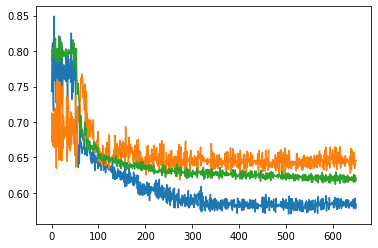

In [48]:
tmp1 = get_data('results/BC_self_learn_encoder_standard_4fold_depth1_666_lamb0.02_results.pkl')
tmp2 = get_data('results/BC_self_learn_encoder_standard_4fold_depth1_700_results.pkl')
tmp3 = get_data('results/test_qrac31_results.pkl/allfolds.pkl')


plt.plot(tmp1['Validation losses (mean)'])
plt.plot(tmp2['Validation losses (mean)'])
plt.plot(tmp3['Validation losses (mean)'])
# plt.plot(tmp['Validation accuracy logs (mean)'])

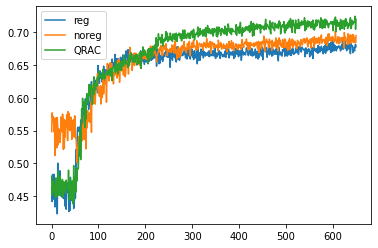

In [50]:
plt.plot(tmp1['Training accuracy logs (mean)'], label='reg')
plt.plot(tmp2['Training accuracy logs (mean)'], label='noreg')
plt.plot(tmp3['Training accuracies (mean)'], label='QRAC')
plt.legend()

In [65]:
tmp2['Validation accuracy logs (mean)'], tmp3['Test accuracies (mean)']

(array([0.62201682, 0.55902778, 0.55208333, 0.60446009, 0.55892997,
        0.5452856 , 0.5764867 , 0.53125   , 0.55550665, 0.56611894,
        0.63952465, 0.48581768, 0.63610133, 0.55203443, 0.47877543,
        0.62901017, 0.51374218, 0.56959116, 0.48224765, 0.63238459,
        0.56597222, 0.57658451, 0.64294797, 0.55213224, 0.57643779,
        0.49955986, 0.55213224, 0.59037559, 0.56602113, 0.54161776,
        0.55545775, 0.56597222, 0.5172144 , 0.66735133, 0.62558685,
        0.54504108, 0.5344777 , 0.60098787, 0.54156886, 0.5905223 ,
        0.63585681, 0.54861111, 0.55550665, 0.57643779, 0.56949335,
        0.55917449, 0.55198552, 0.64632238, 0.5764867 , 0.55555556,
        0.59037559, 0.49618545, 0.65341354, 0.6325313 , 0.60827465,
        0.59756455, 0.53530908, 0.55614241, 0.55262128, 0.51408451,
        0.54191119, 0.50044014, 0.47603678, 0.4622946 , 0.48303013,
        0.47227113, 0.47593897, 0.5108079 , 0.47217332, 0.46562011,
        0.48640454, 0.44107003, 0.53873239, 0.48

<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

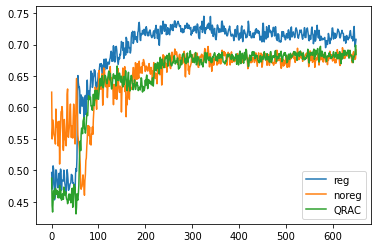

In [64]:
from scipy.signal import savgol_filter
smooth = lambda x: savgol_filter(x, 5, 3)
plt.plot(smooth(tmp1['Validation accuracy logs (mean)']), label='reg')
plt.plot(smooth(tmp2['Validation accuracy logs (mean)']), label='noreg')
plt.plot(smooth(tmp3['Test accuracies (mean)']), label='QRAC')
plt.legend()
plt.ylabel

# MNIST

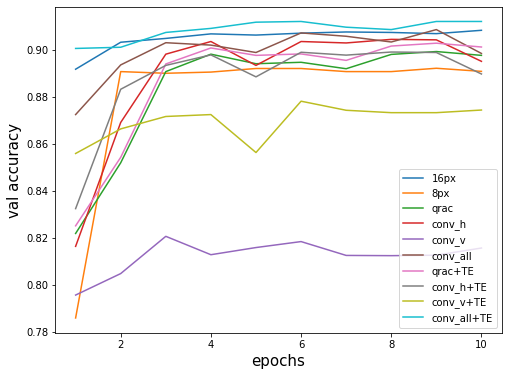

In [4]:
import glob
import pickle

hist = {
    
}

seeds = [111,222,333,444,555]
methods = ['16px', '8px','qrac', 'conv_h', 'conv_v', 'conv_all']

for method in methods:
    hist[method] = {}
    for seed in seeds:
        files = glob.glob(f'results/{method}_11520_10_1_{seed}_log_loss_history.pk')
#         print(files)
        for file in files:
            with open(file, 'rb') as f:
                hist[method][seed] = pickle.load(f)
                
seeds = [111,222,333,444,555]
methods = ['qrac', 'conv_h', 'conv_v', 'conv_all']

for method in methods:
    hist[method+'+TE'] = {}
    for seed in seeds:
        files = glob.glob(f'results/{method}*_10_{seed}_*TE*')
#         print(files)
        if files == []:
            files = glob.glob(f'results/{method}*_10_1_{seed}_*')
        for file in files:
            with open(file, 'rb') as f:
                hist[method+'+TE'][seed] = pickle.load(f)



plt.figure(figsize=(8,6))
for method in hist.keys():
    val_coll = []
    for seed in seeds:
        val_coll.append(hist[method][seed]['val_acc'])
#     print(val_coll)
    x_plot = np.arange(1,11)
    val_mean = np.mean(np.array(val_coll), axis=0)
    val_std = np.std(np.array(val_coll), axis=0)
    plt.plot(x_plot, val_mean, label=method)
    
plt.xlabel('epochs', size=15)
plt.ylabel('val accuracy', size=15)
plt.legend()

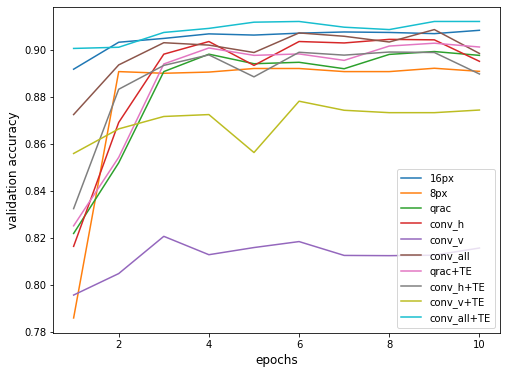

In [8]:
import glob
import pickle

hist = {
    
}

seeds = [111,222,333,444,555]
methods = ['16px', '8px','qrac', 'conv_h', 'conv_v', 'conv_all']

for method in methods:
    hist[method] = {}
    for seed in seeds:
        files = glob.glob(f'results/{method}_11520_10_1_{seed}_log_loss_history.pk')
#         print(files)
        for file in files:
            with open(file, 'rb') as f:
                hist[method][seed] = pickle.load(f)
                
seeds = [111,222,333,444,555]
methods = ['qrac', 'conv_h', 'conv_v', 'conv_all']

for method in methods:
    hist[method+'+TE'] = {}
    for seed in seeds:
        files = glob.glob(f'results/{method}*_10_{seed}_*TE*')
#         print(files)
        if files == []:
            files = glob.glob(f'results/{method}*_10_1_{seed}_*')
        for file in files:
            with open(file, 'rb') as f:
                hist[method+'+TE'][seed] = pickle.load(f)



plt.figure(figsize=(8,6))
for method in hist.keys():
    val_coll = []
    for seed in seeds:
        val_coll.append(hist[method][seed]['val_acc'])
#     print(val_coll)
    x_plot = np.arange(1,11)
    val_mean = np.mean(np.array(val_coll), axis=0)
    val_std = np.std(np.array(val_coll), axis=0)
    plt.plot(x_plot, val_mean, label=method)
    
plt.xlabel('epochs', size=12)
plt.ylabel('validation accuracy', size=12)
plt.legend()

,method,train_acc,std_train,test_acc,std_val,max_train_acc,max_test_acc
0,16px,0.901910,0.012158,0.908232,0.010231,0.910764,0.916667
1,conv_all,0.895538,0.003583,0.898374,0.020840,0.900694,0.912602
2,conv_all+TE,0.911806,0.001472,0.914024,0.000747,0.913542,0.918191
3,conv_41+TE,0.911094,0.001761,0.916870,0.002353,0.913368,0.921240


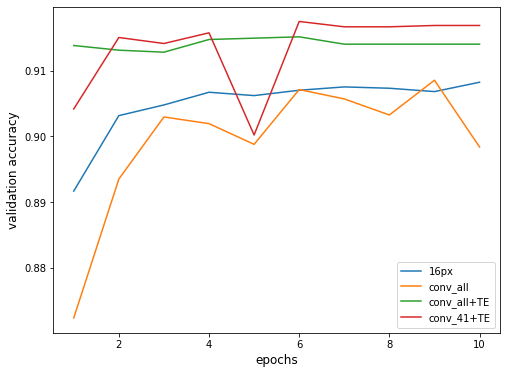

In [89]:
import glob
import pickle

hist = {
    
}

df_data = {
    'method': [],
    'train_acc': [],
    'std_train':[],
    'test_acc':[],
    'std_val':[],
    'max_train_acc':[],
    'max_test_acc':[]
}

seeds = [111,222,333,444,555]
methods = ['16px', 'conv_all']

for method in methods:
    hist[method] = {}
    for seed in seeds:
        files = glob.glob(f'results/{method}_11520_10_1_{seed}_log_loss_history.pk')
#         print(files)
        for file in files:
            with open(file, 'rb') as f:
                hist[method][seed] = pickle.load(f)
                
seeds = [111,222,333,444,555]
methods = [ 'conv_all', 'conv_41']

# 'results/conv_41_11520_10_1_222_log_loss_TE_history.pk'

for method in methods:
    hist[method+'+TE'] = {}
    for seed in seeds:
        files = glob.glob(f'results/{method}_11520_10_1_{seed}_*TE*')
#         print(files)
#         if files == []:
#             files = glob.glob(f'results/{method}*_10_1_{seed}_*')
        
        for file in files:
            with open(file, 'rb') as f:
                hist[method+'+TE'][seed] = pickle.load(f)



plt.figure(figsize=(8,6))
for method in hist.keys():
    train_coll = []
    val_coll = []
    for seed in seeds:
        val_coll.append(hist[method][seed]['val_acc'])
        train_coll.append(hist[method][seed]['acc'])
        
    df_data['method'].append(method)
    df_data['train_acc'].append(np.mean(train_coll, axis=0)[-1])
    df_data['test_acc'].append(np.mean(val_coll, axis=0)[-1])
    df_data['max_train_acc'].append(np.max(train_coll))
    df_data['max_test_acc'].append(np.max(val_coll))
    df_data['std_train'].append(np.std(train_coll, axis=0)[-1])
    df_data['std_val'].append(np.std(val_coll, axis=0)[-1])
#     print(val_coll)
    x_plot = np.arange(1,11)
    val_mean = np.mean(np.array(val_coll), axis=0)
    val_std = np.std(np.array(val_coll), axis=0)
    plt.plot(x_plot, val_mean, label=method)
    

df = pd.DataFrame(data=df_data)
plt.xlabel('epochs', size=12)
plt.ylabel('validation accuracy', size=12)
plt.legend()
df

,method,train_acc,std_train,test_acc,std_val,max_train_acc,max_test_acc
0,8px,0.871476,0.000680,0.890752,0.001541,0.872483,0.897358
1,qrac,0.883142,0.002345,0.897561,0.000996,0.891753,0.907012
2,qrac+TE,0.903403,0.010355,0.912093,0.007937,0.911198,0.918191
3,TE41+TE,0.877899,0.014639,0.870122,0.022472,0.887500,0.882114
4,conv_41_s2+TE,0.858455,0.016986,0.871240,0.026375,0.884809,0.915142


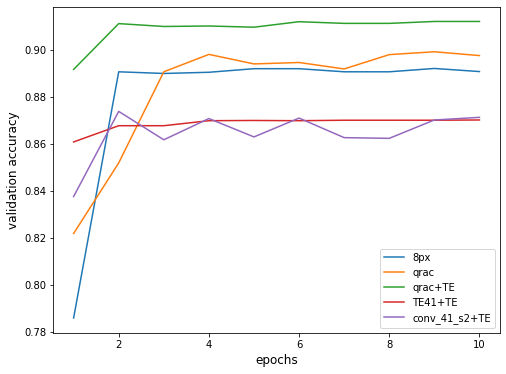

In [85]:
import glob
import pickle

hist = {
    
}

df_data = {
    'method': [],
    'train_acc': [],
    'std_train':[],
    'test_acc':[],
    'std_val':[],
    'max_train_acc':[],
    'max_test_acc':[]
}

seeds = [111,222,333,444,555]
methods = ['8px', 'qrac']

for method in methods:
    hist[method] = {}
    for seed in seeds:
        files = glob.glob(f'results/{method}_11520_10_1_{seed}_log_loss_history.pk')
#         print(files)
        for file in files:
            with open(file, 'rb') as f:
                hist[method][seed] = pickle.load(f)
                
seeds = [111,222,333,444,555]
methods = [ 'qrac', 'TE41', 'conv_41_s2']

for method in methods:
    hist[method+'+TE'] = {}
    for seed in seeds:
        files = glob.glob(f'results/{method}_11520_10_1_{seed}_*TE*')
#         print(files)
#         if files == []:
#             files = glob.glob(f'results/{method}*_10_1_{seed}_*')
        for file in files:
            with open(file, 'rb') as f:
                hist[method+'+TE'][seed] = pickle.load(f)



plt.figure(figsize=(8,6))
for method in hist.keys():
    train_coll = []
    val_coll = []
    for seed in seeds:
        val_coll.append(hist[method][seed]['val_acc'])
        train_coll.append(hist[method][seed]['acc'])
        
    df_data['method'].append(method)
    df_data['train_acc'].append(np.mean(train_coll, axis=0)[-1])
    df_data['test_acc'].append(np.mean(val_coll, axis=0)[-1])
    df_data['max_train_acc'].append(np.max(train_coll))
    df_data['max_test_acc'].append(np.max(val_coll))
    df_data['std_train'].append(np.std(train_coll, axis=0)[-1])
    df_data['std_val'].append(np.std(val_coll, axis=0)[-1])
#     print(val_coll)
    x_plot = np.arange(1,11)
    val_mean = np.mean(np.array(val_coll), axis=0)
    val_std = np.std(np.array(val_coll), axis=0)
    plt.plot(x_plot, val_mean, label=method)
    

df = pd.DataFrame(data=df_data)
plt.xlabel('epochs', size=12)
plt.ylabel('validation accuracy', size=12)
plt.legend()
df

In [80]:
file = 'results/qrac_11520_10_1_444_log_loss_TE_history.pk'

with open(file, 'rb') as f:
    tmp = pickle.load(f)

tmp

{'loss': [0.34242463738967976,
  0.26073179391937124,
  0.26168592715015015,
  0.26021759083701507,
  0.2591228947043419,
  0.2613781256808175,
  0.254305914354821,
  0.2534758601958553,
  0.2536149214332302,
  0.25337019506841896],
 'acc': [0.8561632,
  0.87899303,
  0.87717015,
  0.87916666,
  0.8793403,
  0.88029516,
  0.88324654,
  0.88324654,
  0.88324654,
  0.88324654],
 'val_loss': [0.26698532349210446,
  0.28288761847387484,
  0.2735571555975007,
  0.26987178441954823,
  0.2596401415947007,
  0.26997361798596575,
  0.263623490445013,
  0.26042909920215607,
  0.2622793395587099,
  0.26053256402170755],
 'val_acc': [0.89634144,
  0.8988821,
  0.89634144,
  0.8953252,
  0.89634144,
  0.89634144,
  0.89634144,
  0.89634144,
  0.89634144,
  0.89634144],
 'lr': [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001]}